# Demonstration of Spike Train Analysis Algorithm Replication

Wesley Borden

## Introduction

The second objective of my MS project is to "Implement and experiment with 3-5 algorithms for electrophysiology-based identification of connectome subgraphs with International Brain Lab small animal data". Here, I demonstrate the use of a set of python functions I have developed to replicate these algorithms. I also show simple visualizations of the identified networks.

## Setup

### Imports

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

from brainbox.io.one import SpikeSortingLoader
from iblutil.util import Bunch
from one.alf.io import AlfBunch
from one.api import OneAlyx, ONE  # Docs: https://int-brain-lab.github.io/ONE/

from cc.cc import cross_correlate
from gu.utils import adjacency_matrix_from_pairwise, show_graph
from te.te import transfer_entropy

### API

IBL API as demonstrated in `.../data-demo/nsp_data_demo_jwb.ipynb`

In [2]:
one_alyx: OneAlyx = ONE(
    cache_dir="/Users/wesley/GitHub/BYU/ms-proj/tmp/one-cache",  # any directory where temporary files can be synced
    base_url="https://openalyx.internationalbrainlab.org",  # base url for the API
    password="international",  # public-access password
    silent=True,  # don't print progress, etc.
)  # most 'type: ignore' are because IBL's libraries are less strict on types # type: ignore

In [3]:
data_tag = "2024_Q2_IBL_et_al_BWM_iblsort"  # tag for most recent data release ()
all_sessions: list = one_alyx.search(  # list of sessions
    tag=data_tag, query_type="remote"
)  # type: ignore
n_sessions = len(all_sessions)
print(f"Session count: {n_sessions}")
print(f"Session example: {all_sessions[0]}")

all_insertions: list = one_alyx.search_insertions(  # list of insertions
    tag=data_tag, query_type="remote"
)  # type: ignore
n_insertions = len(all_insertions)
print(f"Insertion count: {n_insertions}")
print(f"Insertion example: {all_insertions[0]}")

Session count: 459
Session example: ebce500b-c530-47de-8cb1-963c552703ea
Insertion count: 699
Insertion example: 8c732bf2-639d-496c-bf82-464bc9c2d54b


In [4]:
# Use the same one for consistency between this demo and other IBL demos
pid_i = 534
pid: str = str(all_insertions[pid_i])
pid_details: tuple[str, str] = one_alyx.pid2eid(pid)
eid, p_name = pid_details

print(f"Probe ID: {pid}")
print(f"Probe Name: {p_name}")
print(f"Experiment ID: {eid}")

Probe ID: 695476f6-4c14-4a2f-b658-948514629079
Probe Name: probe00
Experiment ID: 4720c98a-a305-4fba-affb-bbfa00a724a4


### Load Spike-Sorted Data

As demonstrated in `.../data-demo/nsp_data_demo_jwb.ipynb`

In [5]:
spike_loader = SpikeSortingLoader(pid=pid, one=one_alyx)

In [6]:
spike_sorting_data: tuple[AlfBunch, AlfBunch, Bunch] = spike_loader.load_spike_sorting()  # type: ignore
spikes, clusters, channels = spike_sorting_data

In [7]:
spikes_df = spikes.to_df()
spikes_df

,amps,clusters,depths,times
0,0.000058,512,3413.953125,0.000685
1,0.000077,248,522.224609,0.000818
2,0.000078,89,194.612640,0.000985
3,0.000046,314,877.903320,0.001552
4,0.000067,556,755.919312,0.001552
...,...,...,...,...
27478045,0.000072,287,718.712646,4387.386601
27478046,0.000089,320,859.444580,4387.387934
27478047,0.000050,441,2887.549316,4387.388301
27478048,0.000074,287,714.392090,4387.388468


In [8]:
clusters_wrangled: dict = {}
for k, v in clusters.items():
    if v.ndim == 1:
        clusters_wrangled[k] = v
    elif v.ndim == 2:
        for k_sub in v:
            v_sub = v[k_sub]
            clusters_wrangled[k_sub] = v_sub
    else:
        raise ValueError("Bad dimensions")


clusters_df: pd.DataFrame = pd.DataFrame(clusters_wrangled)
clusters_df

,channels,depths,cluster_id,amp_max,amp_min,amp_median,amp_std_dB,contamination,contamination_alt,drift,...,spike_count,slidingRP_viol_forced,max_confidence,min_contamination,n_spikes_below2,firing_rate,label,bitwise_fail,ks2_label,uuids
0,0,20.0,0,0.000239,0.000066,0.000128,1.202803,0.000614,0.000606,2.410610e+06,...,208337.0,0.0,1.000000e+02,0.5,38,47.485427,1.000000,0,good,2640eb9c-69b4-40db-ab8b-95ad386007da
1,0,20.0,1,0.000101,0.000045,0.000052,1.373974,0.000000,0.000000,9.437402e+03,...,333.0,0.0,2.291341e+00,NaN,0,0.075899,0.333333,3,mua,6245d874-f12d-44a7-9e61-842b648fae9e
2,1,20.0,2,0.000230,0.000059,0.000080,1.968509,0.426780,0.305181,1.334003e+06,...,69774.0,0.0,7.156311e-06,17.0,1969,15.903311,0.333333,3,mua,060ea9a4-5d33-486f-b53d-1562ced5304c
3,1,20.0,3,0.000168,0.000043,0.000051,1.583340,0.762317,0.481094,8.565348e+05,...,36072.0,0.0,7.356894e-05,22.0,1194,8.221748,0.333333,3,mua,4980e5ab-1a1c-428c-b31a-76c901510593
4,1,20.0,4,0.000088,0.000037,0.000042,1.177437,2.055150,0.972173,1.356305e+05,...,6707.0,0.0,6.957768e-11,NaN,87,1.528700,0.000000,7,mua,26df70b8-00ac-4b77-bf99-63d280eb49e5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601,349,3500.0,601,0.000052,0.000044,0.000047,0.454855,0.000000,0.000000,8.965200e+02,...,45.0,0.0,0.000000e+00,NaN,0,0.010257,0.333333,5,mua,348e2d5b-4a53-4b28-943b-85de4115dd03
602,349,3500.0,602,0.000043,0.000032,0.000034,0.613128,0.000000,0.000000,7.628500e+02,...,41.0,0.0,1.998001e-01,NaN,0,0.009345,0.333333,5,mua,ffba0605-08ad-40ce-8dfa-ee80deb8f10e
603,350,3520.0,603,0.000116,0.000051,0.000057,1.019759,0.191065,0.160280,1.833755e+05,...,13735.0,0.0,7.811478e+01,12.0,52,3.130564,0.333333,3,mua,2ede8599-325e-491a-97a0-cbf9421a0ea4
604,294,2960.0,604,0.000080,0.000033,0.000047,1.123559,0.000000,0.000000,8.747828e+03,...,860.0,0.0,5.542513e+01,28.5,0,0.196016,0.333333,5,good,790370fe-a46b-4e46-a13c-fe84ca8fb66b


In [9]:
channels_df = AlfBunch(channels).to_df()
channels_df

,x,y,z,acronym,atlas_id,axial_um,lateral_um,labels,rawInd
0,-0.001907,-0.001250,-0.004395,VPL,718,20.0,43.0,0,0
1,-0.001907,-0.001250,-0.004395,VPL,718,20.0,11.0,0,1
2,-0.001911,-0.001250,-0.004375,VPL,718,40.0,59.0,0,2
3,-0.001911,-0.001250,-0.004375,VPL,718,40.0,27.0,0,3
4,-0.001915,-0.001248,-0.004356,VPL,718,60.0,43.0,0,4
...,...,...,...,...,...,...,...,...,...
379,-0.003074,-0.000558,-0.000952,SSp-bfd2/3,201,3800.0,27.0,0,379
380,-0.003081,-0.000556,-0.000934,SSp-bfd2/3,201,3820.0,43.0,0,380
381,-0.003081,-0.000556,-0.000934,SSp-bfd2/3,201,3820.0,11.0,0,381
382,-0.003087,-0.000555,-0.000915,SSp-bfd2/3,201,3840.0,59.0,0,382


In [10]:
merged_clusters: AlfBunch = spike_loader.merge_clusters(spikes, clusters, channels)  # type: ignore

In [11]:
merged_clusters_df = merged_clusters.to_df()
merged_clusters_df

,channels,depths,uuids,cluster_id,amp_max,amp_min,amp_median,amp_std_dB,contamination,contamination_alt,...,ks2_label,x,y,z,acronym,atlas_id,axial_um,lateral_um,labels,rawInd
0,0,20.0,2640eb9c-69b4-40db-ab8b-95ad386007da,0,0.000239,0.000066,0.000128,1.202803,0.000614,0.000606,...,good,-0.001907,-0.001250,-0.004395,VPL,718,20.0,43.0,0,0
1,0,20.0,6245d874-f12d-44a7-9e61-842b648fae9e,1,0.000101,0.000045,0.000052,1.373974,0.000000,0.000000,...,mua,-0.001907,-0.001250,-0.004395,VPL,718,20.0,43.0,0,0
2,1,20.0,060ea9a4-5d33-486f-b53d-1562ced5304c,2,0.000230,0.000059,0.000080,1.968509,0.426780,0.305181,...,mua,-0.001907,-0.001250,-0.004395,VPL,718,20.0,11.0,0,1
3,1,20.0,4980e5ab-1a1c-428c-b31a-76c901510593,3,0.000168,0.000043,0.000051,1.583340,0.762317,0.481094,...,mua,-0.001907,-0.001250,-0.004395,VPL,718,20.0,11.0,0,1
4,1,20.0,26df70b8-00ac-4b77-bf99-63d280eb49e5,4,0.000088,0.000037,0.000042,1.177437,2.055150,0.972173,...,mua,-0.001907,-0.001250,-0.004395,VPL,718,20.0,11.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601,349,3500.0,348e2d5b-4a53-4b28-943b-85de4115dd03,601,0.000052,0.000044,0.000047,0.454855,0.000000,0.000000,...,mua,-0.002976,-0.000579,-0.001235,SSp-bfd4,1047,3500.0,11.0,0,349
602,349,3500.0,ffba0605-08ad-40ce-8dfa-ee80deb8f10e,602,0.000043,0.000032,0.000034,0.613128,0.000000,0.000000,...,mua,-0.002976,-0.000579,-0.001235,SSp-bfd4,1047,3500.0,11.0,0,349
603,350,3520.0,2ede8599-325e-491a-97a0-cbf9421a0ea4,603,0.000116,0.000051,0.000057,1.019759,0.191065,0.160280,...,mua,-0.002983,-0.000578,-0.001216,SSp-bfd4,1047,3520.0,59.0,0,350
604,294,2960.0,790370fe-a46b-4e46-a13c-fe84ca8fb66b,604,0.000080,0.000033,0.000047,1.123559,0.000000,0.000000,...,good,-0.002809,-0.000692,-0.001730,SSp-bfd6a,1038,2960.0,59.0,0,294


### Timeframe

As demonstrated in `.../data-demo/nsp_data_demo_jwb.ipynb`

In [12]:
start_time = 150  # seconds since beginning the electrophysiology recording
end_time = 152  # seconds since beginning the electrophysiology recording

In [13]:
spikes_df_timeframe = spikes_df[start_time <= spikes_df["times"]]
spikes_df_timeframe = spikes_df_timeframe[spikes_df_timeframe["times"] <= end_time]
spikes_df_timeframe

,amps,clusters,depths,times
1064505,0.000179,213,500.639526,150.000098
1064506,0.000068,287,792.859009,150.000198
1064507,0.000071,76,193.428528,150.000298
1064508,0.000028,374,1119.744629,150.000465
1064509,0.000173,190,459.618500,150.000598
...,...,...,...,...
1080372,0.000131,218,524.351562,151.999812
1080373,0.000071,180,407.717468,151.999812
1080374,0.000066,355,1000.125610,151.999846
1080375,0.000325,129,294.618591,151.999946


### Determine Bin Size

In `.../data-demo/nsp_data_demo_jwb.ipynb`, we used high-resolution bins that slowed down processing. For spike train analysis, we can tune bin size as a hyperparameter. We will use a 10ms bins size, which aligns with a prior study (Moore, 1970, Statistical Signs of Synaptic Interaction in Neurons, https://doi.org/10.1016/S0006-3495(70)86341-X)

In [14]:
bins_per_s = 100 # each bin is 10ms

### Wrangle to Clusters-by-Time Matrix

Adapted from `.../data-demo/nsp_data_demo_jwb.ipynb`

In [15]:
cluster_channel_map = (
    merged_clusters_df[["cluster_id", "channels"]]
    .copy()
    .sort_values(by="channels", ascending=True)
    .reset_index(drop=True)
    .reset_index(drop=False)
    .rename(inplace=False, columns={"index": "cluster_channel_id"})
)
cluster_channel_map

,cluster_channel_id,cluster_id,channels
0,0,0,0
1,1,1,0
2,2,2,1
3,3,3,1
4,4,4,1
...,...,...,...
601,601,538,367
602,602,590,367
603,603,592,367
604,604,539,371


In [16]:
spikes_df_timeframe = spikes_df_timeframe.merge(
    cluster_channel_map, left_on="clusters", right_on="cluster_id", how="left"
)
spikes_df_timeframe["time_bin"] = (np.floor((spikes_df_timeframe["times"] - start_time) * bins_per_s)).astype(int)  # bin by microsecond
spikes_df_timeframe

,amps,clusters,depths,times,cluster_channel_id,cluster_id,channels,time_bin
0,0.000179,213,500.639526,150.000098,219,213,48,0
1,0.000068,287,792.859009,150.000198,300,287,73,0
2,0.000071,76,193.428528,150.000298,73,76,14,0
3,0.000028,374,1119.744629,150.000465,396,374,106,0
4,0.000173,190,459.618500,150.000598,195,190,42,0
...,...,...,...,...,...,...,...,...
15867,0.000131,218,524.351562,151.999812,225,218,49,199
15868,0.000071,180,407.717468,151.999812,187,180,41,199
15869,0.000066,355,1000.125610,151.999846,376,355,98,199
15870,0.000325,129,294.618591,151.999946,130,129,29,199


In [17]:
clusters_spikes_matrix = np.zeros(
    (cluster_channel_map.shape[0], ((end_time - start_time) * bins_per_s))
)  # type: ignore
clusters_spikes_matrix[
    (
        spikes_df_timeframe["cluster_channel_id"].max()
        - spikes_df_timeframe["cluster_channel_id"].values
    ),
    spikes_df_timeframe["time_bin"].values,
] = int(1)  # 1 represents a spike # type: ignore
clusters_spikes_matrix

array([[0., 1., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 1., 0., 0.]], shape=(606, 200))

### Visualize Spike Trains

As demonstrated in `.../data-demo/nsp_data_demo_jwb.ipynb`

Text(0, 0.5, 'Putative Neuron')

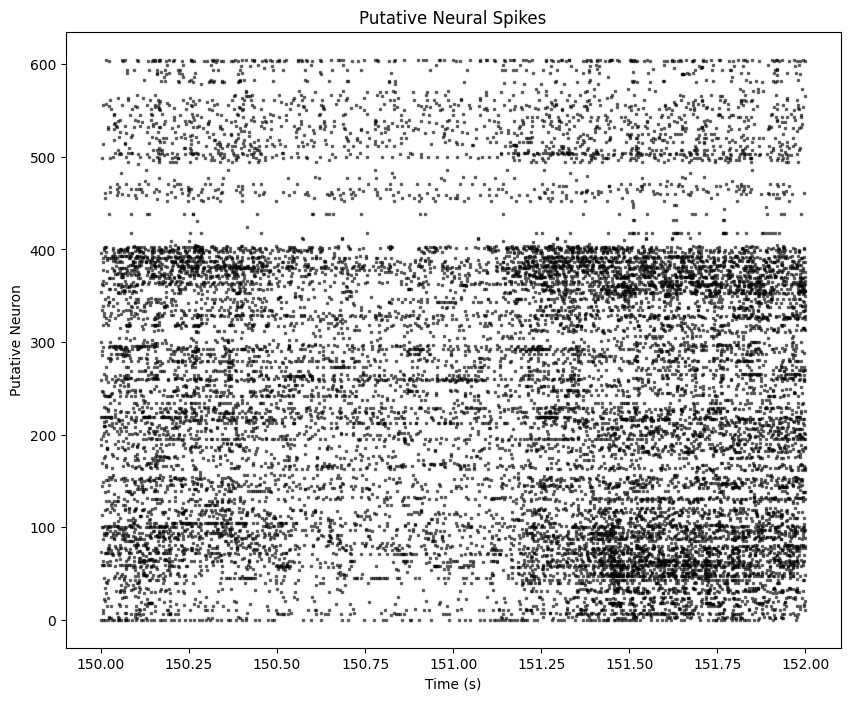

In [18]:
fig, axs = plt.subplots(figsize=(10, 8))

axs.scatter(
    spikes_df_timeframe["times"].values,  # type: ignore
    spikes_df_timeframe["cluster_channel_id"].values,  # type: ignore
    s=1,
    alpha=0.5,
    c="#000000",
    marker="s",
)

axs.set_title("Putative Neural Spikes")
axs.set_xlabel("Time (s)")
axs.set_ylabel("Putative Neuron")

### Notes

Everything to this point has been copied or adapted from `.../data-demo/nsp_data_demo_jwb.ipynb`. Now we will show how to use the data to identify a biological neural network: a partial connectome.

## Cross Correlation

Cross correlation involves a sliding dot product of two vectors that represent parallel spike trains. The resulting distribution includes outliers if there is a significant correlation between the two spike trains. This is implemented in `cross_correlate`, which returns a category as follows:

|Category | Meaning |
|---|---|
|  1| relationship |
|  0| no relationship |

In [19]:
print(f"Comparing a spike train to itself returns {cross_correlate(clusters_spikes_matrix[0], clusters_spikes_matrix[0])}")
print(f"Comparing a spike train to a distant spike train returns {cross_correlate(clusters_spikes_matrix[0], clusters_spikes_matrix[-1])}")

Comparing a spike train to itself returns 1
Comparing a spike train to a distant spike train returns 0


In [20]:
sample_limit = 10
sample_count = 0
for i, _ in enumerate(clusters_spikes_matrix):
    for j in range(i+1, min(i+100, len(clusters_spikes_matrix))):
        if cross_correlate(clusters_spikes_matrix[i], clusters_spikes_matrix[j]):
            sample_count += 1
            print(f"Spike train {i} is functionally connected to spike train {j}")
            if sample_count >= sample_limit:
                break
    if sample_count >= sample_limit:
        break 


Spike train 0 is functionally connected to spike train 7
Spike train 0 is functionally connected to spike train 8
Spike train 0 is functionally connected to spike train 9
Spike train 0 is functionally connected to spike train 10
Spike train 0 is functionally connected to spike train 14
Spike train 0 is functionally connected to spike train 17
Spike train 0 is functionally connected to spike train 32
Spike train 0 is functionally connected to spike train 34
Spike train 0 is functionally connected to spike train 38
Spike train 0 is functionally connected to spike train 39


We can use cross correlation to construct an adjacency matrix and a graph:

In [21]:
adjacency_matrix_from_cc = adjacency_matrix_from_pairwise(clusters_spikes_matrix, cross_correlate)
g_from_cc = nx.from_numpy_array(adjacency_matrix_from_cc)

Let's visualize the resulting graph

<Figure size 640x480 with 0 Axes>

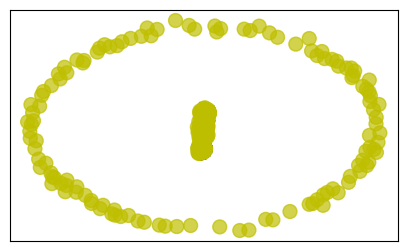

In [22]:
show_graph(g_from_cc, (5, 3))

That gave a lot of unconnected nodes. Let's look at the largest component

<Figure size 640x480 with 0 Axes>

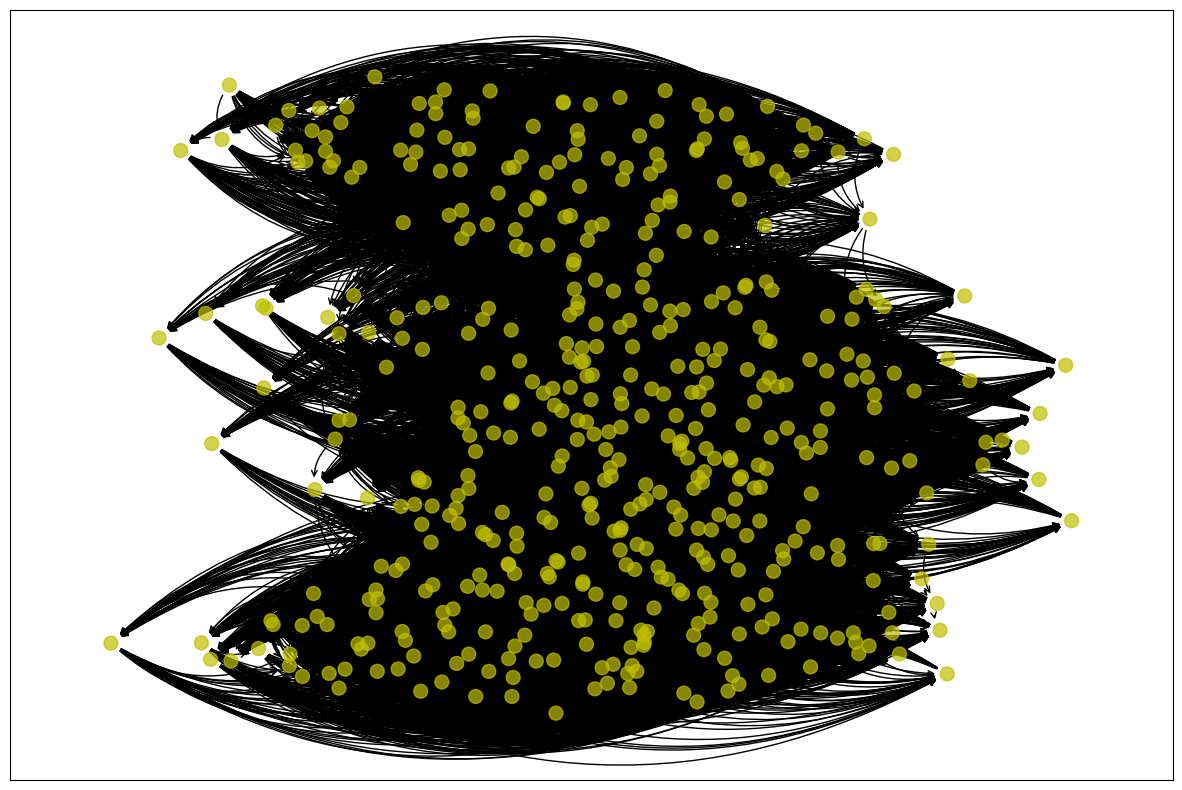

In [23]:
largest_connected_component_nodes_cc = max(nx.connected_components(g_from_cc), key=len)
largest_connected_component_subgr_cc = g_from_cc.subgraph(largest_connected_component_nodes_cc).copy()
show_graph(largest_connected_component_subgr_cc, layout_fun_ = nx.spring_layout)


## Transfer Entropy

Transfer entropy could be described as how much the outcome of time series Y is described by time series X, considering L timepoints in history.

In [24]:
print(f"Comparing a spike train to itself returns {transfer_entropy(clusters_spikes_matrix[0], clusters_spikes_matrix[0])}")
print(f"Comparing a spike train to a distant spike train returns {transfer_entropy(clusters_spikes_matrix[0], clusters_spikes_matrix[-1])}")

Comparing a spike train to itself returns 0
Comparing a spike train to a distant spike train returns 1


In [25]:
sample_limit = 10
sample_count = 0
for i, _ in enumerate(clusters_spikes_matrix):
    for j in range(i+1, min(i+100, len(clusters_spikes_matrix))):
        if transfer_entropy(clusters_spikes_matrix[i], clusters_spikes_matrix[j]) > 0: #TODO
            sample_count += 1
            print(f"Spike train {i} is functionally connected to spike train {j}")
            if sample_count >= sample_limit:
                break
    if sample_count >= sample_limit:
        break 


Spike train 0 is functionally connected to spike train 1
Spike train 0 is functionally connected to spike train 11
Spike train 0 is functionally connected to spike train 13
Spike train 0 is functionally connected to spike train 14
Spike train 0 is functionally connected to spike train 15
Spike train 0 is functionally connected to spike train 23
Spike train 0 is functionally connected to spike train 35
Spike train 0 is functionally connected to spike train 43
Spike train 0 is functionally connected to spike train 44
Spike train 0 is functionally connected to spike train 45


We can use transfer entropy to construct an adjacency matrix and a graph:

In [26]:
adjacency_matrix_from_te = adjacency_matrix_from_pairwise(clusters_spikes_matrix, transfer_entropy)
g_from_te = nx.from_numpy_array(adjacency_matrix_from_te, create_using=nx.DiGraph)

Let's visualize the resulting graph and largest connected component

<Figure size 640x480 with 0 Axes>

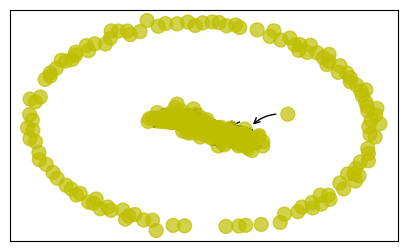

<Figure size 640x480 with 0 Axes>

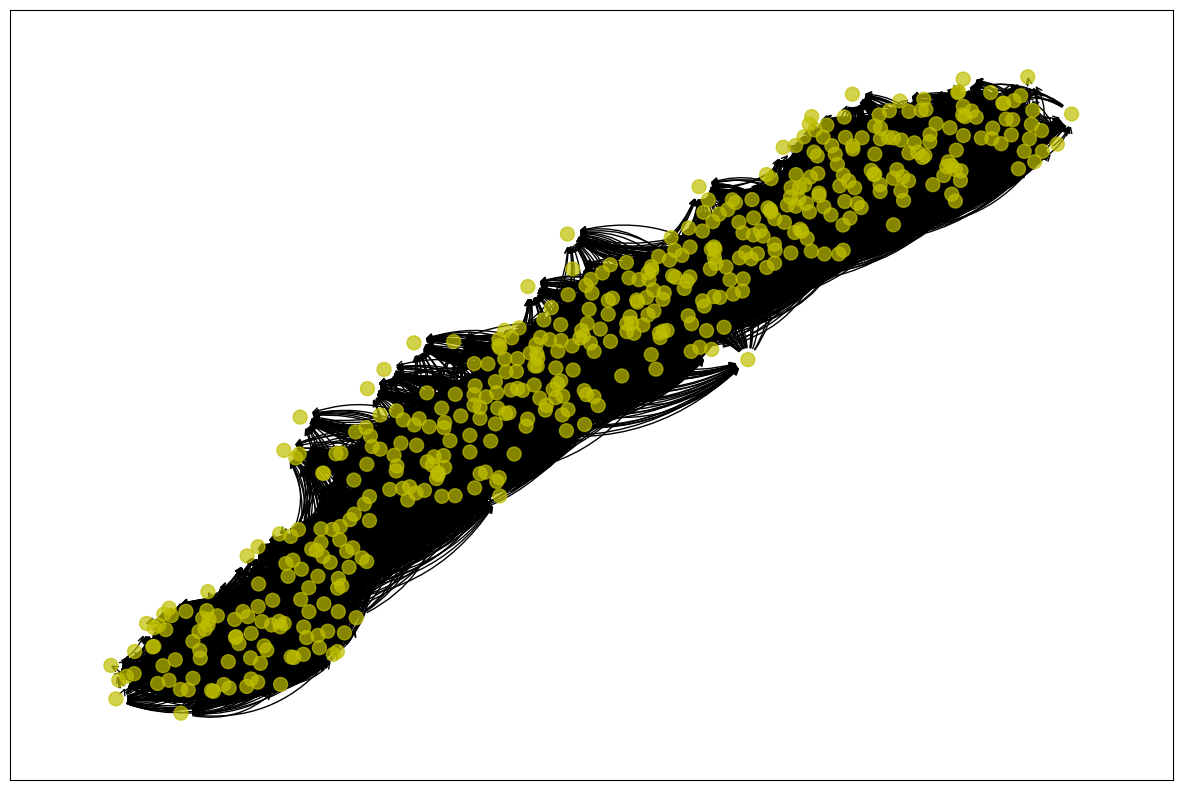

In [27]:
show_graph(g_from_te, (5, 3))

largest_connected_component_nodes_te = max(nx.weakly_connected_components(g_from_te), key=len)
largest_connected_component_subgr_te = g_from_cc.subgraph(largest_connected_component_nodes_te).copy()
show_graph(largest_connected_component_subgr_te, layout_fun_ = nx.spring_layout)
